In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.layers import LeakyReLU, PReLU, ELU, ParametricSoftplus, ThresholdedLinear, ThresholdedReLU, SReLU

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.regularizers import l1, l2, l1l2
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras import backend as K

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

Using Theano backend.
Using gpu device 0: GeForce GTX 670 (CNMeM is disabled, CuDNN 4007)


In [2]:
categories = [
  'good_for_lunch', 
  'good_for_dinner', 
  'takes_reservations', 
  'outdoor_seating',
  'restaurant_is_expensive',
  'has_alcohol',
  'has_table_service',
  'ambience_is_classy',
  'good_for_kids'
]

vgg_cols = ['f' + str(i) for i in range(4096)]

In [3]:
data = pd.read_hdf('data/Xtrain_grouped.hdf5')
X, Y = np.array(data[vgg_cols]), np.array(data[categories])

random_state = np.random.RandomState(0)
Xtrain, Xval, ytrain, yval = train_test_split(X, Y, test_size=.2, random_state=random_state)
valset = (Xval, yval)

print Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

(1596, 4096) (400, 4096) (1596, 9) (400, 9)


In [4]:
mlb = MultiLabelBinarizer()
mlb.fit([(0,1,2,3,4,5,6,7,8)])

dataTest = None
for i in range(1, 7):
  part = pd.read_hdf('data/Xtest_grouped_part' + str(i) + '.hdf5', 'Xtest')
  print i, len(part)
  
  if dataTest is None:
    dataTest = part
  else:
    dataTest = dataTest.append(part)
    
Xtest = np.array(dataTest[vgg_cols])
Xtest.shape

1 1637
2 1707
3 1654
4 1746
5 1735
6 1521


(10000, 4096)

In [5]:
def loss(ytrue, ypred):
  return K.sum( (ytrue - ypred) ** 2 )

In [6]:
class f1printerCallback(Callback):
  def __init__(self):
    self.bestf1val = 0

  def on_epoch_end(self, epoch, logs={}):
    pred = self.model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred > .5] = 1
    f1_val = f1_score(yval, pred, average='micro')

    if f1_val > self.bestf1val:
      print 'Epoch %d -- val %f (micro %f)' % (epoch, f1_val, f1_score(yval, pred, average='micro'))
      self.bestf1val = f1_val

# Train models

In [15]:
neurons = range(50, 501, 50)
neurons

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [16]:
dropout_vals = np.linspace(.1, .5, 9)
dropout_vals

array([ 0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ])

In [17]:
def get_model(n_neurons, dropout_val):
  model = Sequential()
  np.random.seed(0)
  
  model.add(Dense(n_neurons, input_shape=(4096,), activation='softplus'))
  model.add(Dropout(dropout_val))

  model.add(Dense(9, activation='sigmoid'))
  model.compile(loss=loss, optimizer='adam')
  
  return model

In [19]:
models = []

for neu in n_neurons:
  for dro in dropout_vals:
    model = get_model(neu, dro)
    model.fit(Xtrain, ytrain, verbose=0)
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred > .5] = 1
    f1_val = f1_score(yval, pred, average='micro')
    print neu, dro, f1_val
    
    models.append((f1_val, model))

50 0.1 0.837531137559
50 0.15 0.838850889193
50 0.2 0.837248322148
50 0.25 0.838383838384
50 0.3 0.833095577746
50 0.35 0.83189902467
50 0.4 0.831990794016
50 0.45 0.832997987928
50 0.5 0.829525483304
100 0.1 0.829595106321
100 0.15 0.827646038172
100 0.2 0.833716915995
100 0.25 0.839703365659
100 0.3 0.837209302326
100 0.35 0.834682080925
100 0.4 0.833285673434
100 0.45 0.835906232133
100 0.5 0.836510687464
150 0.1 0.82848262221
150 0.15 0.826200873362
150 0.2 0.833666191155
150 0.25 0.836322231711
150 0.3 0.833476149672
150 0.35 0.836519258203
150 0.4 0.833850493653
150 0.45 0.839809896561
150 0.5 0.84246188594
200 0.1 0.835177304965
200 0.15 0.829578278452
200 0.2 0.832764505119
200 0.25 0.829962973512
200 0.3 0.83612610054
200 0.35 0.835537665325
200 0.4 0.825378346915
200 0.45 0.828713160198
200 0.5 0.825287356322
250 0.1 0.83409350057
250 0.15 0.828306264501
250 0.2 0.828563168546
250 0.25 0.823322590097
250 0.3 0.829954954955
250 0.35 0.832622904234
250 0.4 0.833286318759
250 0.

In [23]:
sorted_by_f1val = sorted(models, key=lambda t: -t[0])

In [24]:
for s in sorted_by_f1val:
  print s[0],

0.84246188594 0.84057158868 0.840506329114 0.839809896561 0.839703365659 0.839428571429 0.839301059868 0.839240147434 0.839230983561 0.838850889193 0.838802533103 0.838541666667 0.838383838384 0.837611607143 0.837531137559 0.83735277622 0.837248322148 0.837236195432 0.837209302326 0.836820083682 0.836560364465 0.836530203264 0.836519258203 0.836510687464 0.836322231711 0.83612610054 0.835906232133 0.835537665325 0.835537665325 0.83545034642 0.83545018346 0.835177304965 0.834967778089 0.834682080925 0.834645669291 0.834597023308 0.834433285509 0.83409350057 0.833896396396 0.833850493653 0.833850493653 0.833814195038 0.833716915995 0.833666191155 0.833476149672 0.833286318759 0.833285673434 0.833095577746 0.832997987928 0.832953249715 0.832764505119 0.832622904234 0.832487309645 0.832041343669 0.831990794016 0.83189902467 0.831889081456 0.831644144144 0.831370295892 0.83110984956 0.830926083263 0.830670926518 0.830351990767 0.830050647158 0.829962973512 0.829954954955 0.829854160709 0.82

In [36]:
def get_best_models(n_models):
  best_models = []
  
  for s in sorted_by_f1val:
#     print s[0]
    best_models.append(s[1])
    
    if len(best_models) >= n_models:
      break
    
  return best_models

In [26]:
def predict_ensemble(models, X):
  pred = np.zeros((len(models), X.shape[0], 9))
  
  for idx, model in enumerate(models):
    pred[idx] = model.predict(X)
    
  result = pred.mean(axis=0)
  assert result.shape[0] == X.shape[0]
  assert result.shape[1] == 9
  return result

In [40]:
f1s = []

for i in range(len(models)):  
  pred = predict_ensemble(get_best_models(i + 1), Xval)
  pred[pred < .5] = 0
  pred[pred > .5] = 1
  
  f1s.append(f1_score(yval, pred, average='micro'))

In [42]:
np.argmax(f1s)

38

In [43]:
f1s[37:40]

[0.84335981838819518, 0.84458309699376044, 0.84425531914893615]

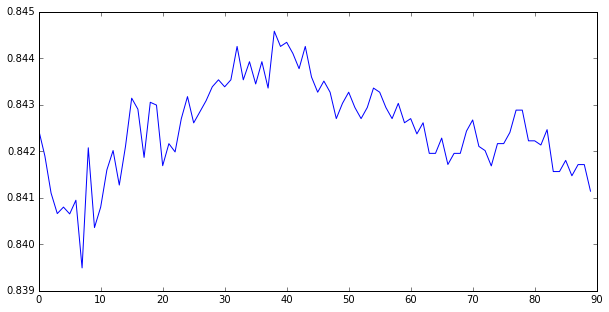

In [41]:
plt.plot(np.arange(len(models)), f1s)

In [47]:
pred = predict_ensemble(get_best_models(19), Xval)
pred[pred < .5] = 0
pred[pred > .5] = 1

f1_score(yval, pred, average='micro')

0.84305438151592005

# Test data predictions

In [48]:
# pred = model.predict(Xtest)
pred = predict_ensemble(get_best_models(19), Xtest)

pred[pred < .5] = 0
pred[pred > .5] = 1
labels = mlb.inverse_transform(pred)
labels_str = [' '.join(map(str, l)) for l in labels]
results = pd.DataFrame({'business_id': dataTest.index, 'labels': pd.Series(labels_str)})
results.head()

,business_id,labels
0,003sg,1 2 3 5 6 8
1,00er5,1 2 3 5 6 8
2,00kad,1 2 3 5 6 8
3,00mc6,1 2 4 5 6
4,00q7x,1 2 4 5 6 7


In [49]:
results.to_csv('results/second_ensemble_19models.csv', index=False)